Device: cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Usage: python resnet.py <argument>
No argument given, presuming --full-test


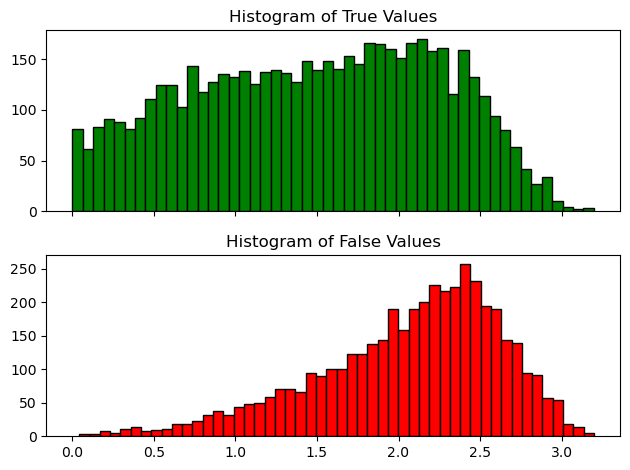

Accuracy of the network on the 10000 test images: 55.52%


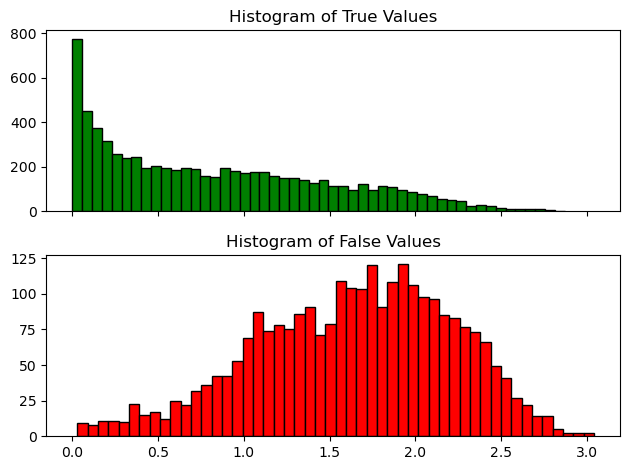

Accuracy of the network on the 10000 test images: 73.04%


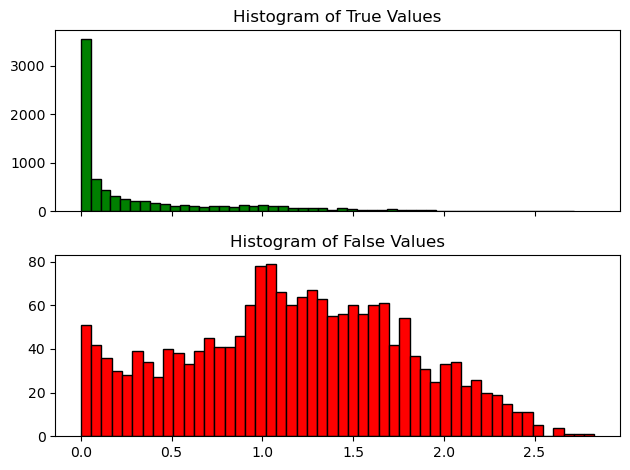

Accuracy of the network on the 10000 test images: 81.12%


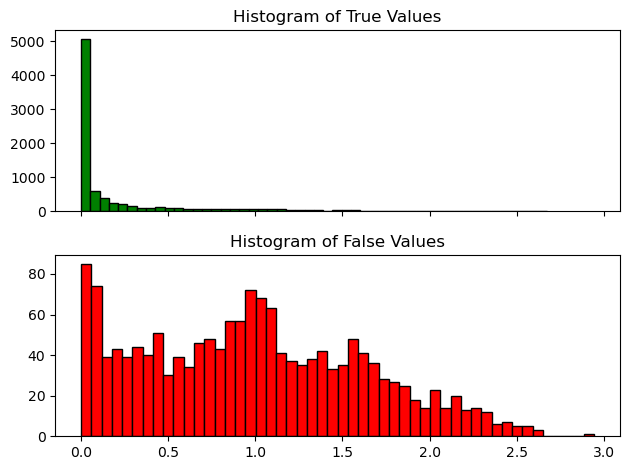

Accuracy of the network on the 10000 test images: 84.07%


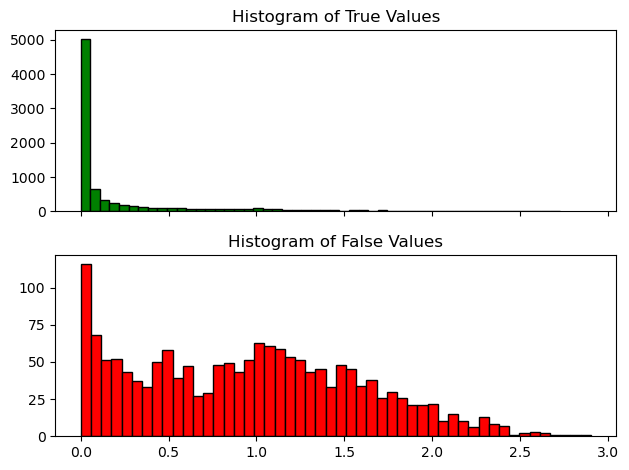

Accuracy of the network on the 10000 test images: 83.59%


In [9]:
# Done using the following tutorial, not my own work
# https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import time
import matplotlib.pyplot as plt
from math import log2
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

def data_loader(data_dir, batch_size, random_seed=42, valid_size=0.1, shuffle=True, test=False):
    # Values specific to CIFAR-10 dataset
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])

    # define transforms
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

    if test:
        dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)
test_loader = data_loader(data_dir='./data', batch_size=64, test=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class ResnetLayer1(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer1, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(160000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer2(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer2, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(61952, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer3(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer3, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(16384, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer4(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer4, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

def train(model):
    model.train()
# Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

    import gc
    total_step = len(train_loader)
    print(f"Total Steps: {total_step}")

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Image: {i}, Label: {labels}")
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        print (f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
                
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
        
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

def test(model):
    entropyVsCorrectness = {}
    
    with torch.no_grad():
        correct = 0
        total = 0
        j = 0
        # print(f"Number of sections: {len(test_loader)}")
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            y_hat = torch.nn.functional.softmax(outputs, dim=1)
            entropy = -torch.sum(y_hat * torch.log2(y_hat), dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for a, b in zip(entropy, predicted == labels):
                entropyVsCorrectness[j] = (a.item(), b.item())
                j += 1

        json_data = json.dumps(entropyVsCorrectness)
        with open("data_file.json", "a") as file:
            file.write(json_data + "\n")

# Initialize empty lists for True and False values
        true_list = []
        false_list = []

# Iterate through the dictionary and populate the lists
        for key, value in entropyVsCorrectness.items():
            if value[1] is True:
                true_list.append(value[0])
            else:
                false_list.append(value[0])

# Sort the lists in ascending order
        true_list.sort()
        false_list.sort()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.hist(true_list, color="green", ec="black", bins = 50)
        ax2.hist(false_list, color="red", ec="black", bins = 50)


        ax1.set_title("Histogram of True Values")
        ax2.set_title("Histogram of False Values")

        plt.tight_layout()
        plt.show(block=False)
        print(f"Accuracy of the network on the {10000} test images: {100 * correct / total}%")

def fullTest():
    model0state = torch.load("models/model0", map_location=torch.device("cpu"))
    model1state = torch.load("models/model1", map_location=torch.device("cpu"))
    model2state = torch.load("models/model2", map_location=torch.device("cpu"))
    model3state = torch.load("models/model3", map_location=torch.device("cpu"))
    modelfullstate = torch.load("models/modelfull", map_location=torch.device("cpu"))

    model0 = ResnetLayer1(ResidualBlock, [3, 4, 6, 3]).to(device)
    model1 = ResnetLayer2(ResidualBlock, [3, 4, 6, 3]).to(device)
    model2 = ResnetLayer3(ResidualBlock, [3, 4, 6, 3]).to(device)
    model3 = ResnetLayer4(ResidualBlock, [3, 4, 6, 3]).to(device)
    modelfull = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

    model0.load_state_dict(model0state)
    model1.load_state_dict(model1state)
    model2.load_state_dict(model2state)
    model3.load_state_dict(model3state)
    modelfull.load_state_dict(modelfullstate)

    models = [model0, model1, model2, model3, modelfull]
    i = 0
    for model in models:
        print(f"Test {i}")
        i = i + 1
        test(model)

def fullTrain():
# This is ResNet50
# Resnet50, Resnet101 and resnet152 all have a similar architecture, Resnet18 and Resnet34 are different
# Not an issue for me, just use the bigger models since branches shouldnt matter on smaller models
# Come back and try the smaller ones later when the branches actually work
    model0 = ResnetLayer1(ResidualBlock, [3, 4, 6, 3]).to(device)
    train(model0)
    model0.eval()
    # TODO: Save the architecture as well
    torch.save(model0.state_dict(), "models/model0")

    model1 = ResnetLayer2(ResidualBlock, [3, 4, 6, 3]).to(device)
    train(model1)
    model1.eval()
    torch.save(model1.state_dict(), "models/model1")

    model2 = ResnetLayer3(ResidualBlock, [3, 4, 6, 3]).to(device)
    train(model2)
    model2.eval()
    torch.save(model2.state_dict(), "models/model2")

    model3 = ResnetLayer4(ResidualBlock, [3, 4, 6, 3]).to(device)
    train(model3)
    model3.eval()
    torch.save(model3.state_dict(), "models/model3")

    modelfull = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
    train(modelfull)
    modelfull.eval()
    torch.save(modelfull.state_dict(), "models/modelfull")

def main():
    if len(sys.argv) != 2:
        print("Usage: python resnet.py <argument>")

    argument = sys.argv[1]

    if argument == "--full-train":
        fullTrain()
    elif argument == "--full-test":
        fullTest()
    else:
        print(f"No argument given, presuming --full-test")
        fullTest()

if __name__ == "__main__":
    main()